# Waste Clssifier Image Classification Model


## 1. Loading Data

In [68]:
!pip install torch
!pip install torchvision
!pip install kagglehub


In [1]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
class GarbageDataset(Dataset):
    def __init__(self, root, transform=None):

        self.root = root
        self.transform = transform

        # Get all class folders
        self.classes = sorted([d for d in os.listdir(root)
                              if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Build list of (image_path, label) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
import kagglehub
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

print("\nContents of dataset directory:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/ - {len(os.listdir(item_path))} items")
    else:
        print(f"📄 {item}")

# Check one level deeper
print("\nLooking deeper:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        for subitem in os.listdir(item_path)[:5]:  # Show first 5 items
            print(f"  {item}/{subitem}")

Path to dataset files: C:\Users\Yousef Shahin\.cache\kagglehub\datasets\zlatan599\garbage-dataset-classification\versions\5

Contents of dataset directory:
📁 Garbage_Dataset_Classification/ - 2 items

Looking deeper:
  Garbage_Dataset_Classification/images
  Garbage_Dataset_Classification/metadata.csv


In [135]:
import random

dataset_path = os.path.join(path, "Garbage_Dataset_Classification", "images")

# Define ImageNet normalization stats
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
# Load full dataset
# full_dataset = GarbageDataset(
#     root=dataset_path,
#     transform=transform
# )
full_dataset = GarbageDataset(
    root=dataset_path,
    transform=None
)
# Randomly sample
num_samples = int(len(full_dataset))
indices = random.sample(range(len(full_dataset)), num_samples)

# Get corresponding labels
labels = [full_dataset.samples[i][1] for i in indices]

# Split 80/20 train/test with stratification
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_dataset = GarbageDataset(
    root=dataset_path,
    transform=train_tf
)
test_dataset = GarbageDataset(
    root=dataset_path,
    transform=test_tf
)

train_data = Subset(train_dataset, train_indices)
test_data = Subset(test_dataset, test_indices)

print(f"Total samples: {len(full_dataset)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Classes: {full_dataset.classes}")

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# get the length of the output:
print(f"Output length: {len(full_dataset.classes)}")

Total samples: 13901
Train samples: 11120
Test samples: 2781
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Output length: 6


## 2. Visualizing the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224])


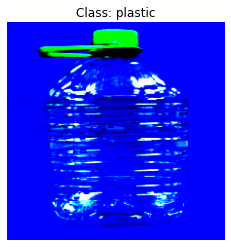

In [121]:
#show random image from train_data
random_num = random.randint(0, len(train_data)-1)
image,label = train_data[random_num]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class: {full_dataset.classes[label]}")
plt.axis('off')
plt.show()

## 3. Creating the Model

In [122]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

This model uses Convolutional Nerual Networks to classify images

In [ ]:
class WasteClassifierModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # x = self.block4(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

In [124]:
torch.manual_seed(42)
model_1 = WasteClassifierModelV1(input_shape=3, hidden_units=64, output_shape=len(full_dataset.classes)).to(device)
model_1

WasteClassifierModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### setting up loss function and optimizer

In [125]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

In [126]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [127]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Training model

In [128]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [129]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)

train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []
# Measure time
train_time_start_model_1 = timer()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
)
# Train and test model
epochs = 45
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_loader ,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss, test_acc = test_step(data_loader=test_loader ,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    scheduler.step(test_acc)

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

c:\Users\Yousef Shahin\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.65212 | Train accuracy: 32.33%


  2%|▏         | 1/45 [00:54<39:37, 54.04s/it]

Test loss: 1.51110 | Test accuracy: 41.60%

Epoch: 1
---------
Train loss: 1.50308 | Train accuracy: 42.46%


  4%|▍         | 2/45 [01:47<38:24, 53.59s/it]

Test loss: 1.38352 | Test accuracy: 47.46%

Epoch: 2
---------
Train loss: 1.40067 | Train accuracy: 47.38%


  7%|▋         | 3/45 [02:40<37:27, 53.50s/it]

Test loss: 1.28859 | Test accuracy: 52.50%

Epoch: 3
---------
Train loss: 1.32477 | Train accuracy: 50.57%


  9%|▉         | 4/45 [03:33<36:28, 53.38s/it]

Test loss: 1.24835 | Test accuracy: 54.50%

Epoch: 4
---------
Train loss: 1.25323 | Train accuracy: 53.24%


 11%|█         | 5/45 [04:27<35:32, 53.31s/it]

Test loss: 1.26262 | Test accuracy: 53.72%

Epoch: 5
---------
Train loss: 1.19980 | Train accuracy: 56.10%


 13%|█▎        | 6/45 [05:20<34:36, 53.26s/it]

Test loss: 1.07826 | Test accuracy: 60.48%

Epoch: 6
---------
Train loss: 1.14106 | Train accuracy: 58.42%


 16%|█▌        | 7/45 [06:14<34:02, 53.74s/it]

Test loss: 1.07146 | Test accuracy: 61.25%

Epoch: 7
---------
Train loss: 1.07346 | Train accuracy: 61.13%


 18%|█▊        | 8/45 [07:08<33:03, 53.60s/it]

Test loss: 1.09325 | Test accuracy: 61.81%

Epoch: 8
---------
Train loss: 1.04038 | Train accuracy: 62.46%


 20%|██        | 9/45 [08:01<32:05, 53.49s/it]

Test loss: 0.94141 | Test accuracy: 66.06%

Epoch: 9
---------
Train loss: 1.00546 | Train accuracy: 63.54%


 22%|██▏       | 10/45 [08:54<31:11, 53.47s/it]

Test loss: 0.96572 | Test accuracy: 66.10%

Epoch: 10
---------
Train loss: 0.94156 | Train accuracy: 66.54%


 24%|██▍       | 11/45 [09:48<30:20, 53.54s/it]

Test loss: 0.92506 | Test accuracy: 65.58%

Epoch: 11
---------
Train loss: 0.93255 | Train accuracy: 66.67%


 27%|██▋       | 12/45 [10:42<29:26, 53.54s/it]

Test loss: 0.90470 | Test accuracy: 69.00%

Epoch: 12
---------
Train loss: 0.87090 | Train accuracy: 68.94%


 29%|██▉       | 13/45 [11:33<28:13, 52.93s/it]

Test loss: 0.83969 | Test accuracy: 69.73%

Epoch: 13
---------
Train loss: 0.86234 | Train accuracy: 69.23%


 31%|███       | 14/45 [12:25<27:07, 52.50s/it]

Test loss: 0.83239 | Test accuracy: 70.84%

Epoch: 14
---------
Train loss: 0.81386 | Train accuracy: 71.26%


 33%|███▎      | 15/45 [13:16<26:05, 52.20s/it]

Test loss: 0.82708 | Test accuracy: 70.44%

Epoch: 15
---------
Train loss: 0.78316 | Train accuracy: 72.19%


 36%|███▌      | 16/45 [14:08<25:06, 51.96s/it]

Test loss: 0.81840 | Test accuracy: 70.08%

Epoch: 16
---------
Train loss: 0.75137 | Train accuracy: 73.58%


 38%|███▊      | 17/45 [14:59<24:12, 51.88s/it]

Test loss: 0.74191 | Test accuracy: 74.59%

Epoch: 17
---------
Train loss: 0.73229 | Train accuracy: 74.37%


 40%|████      | 18/45 [15:54<23:47, 52.86s/it]

Test loss: 0.73013 | Test accuracy: 74.08%

Epoch: 18
---------
Train loss: 0.69594 | Train accuracy: 75.14%


 42%|████▏     | 19/45 [16:49<23:05, 53.28s/it]

Test loss: 0.75474 | Test accuracy: 74.17%

Epoch: 19
---------
Train loss: 0.66987 | Train accuracy: 76.44%


 44%|████▍     | 20/45 [17:42<22:14, 53.37s/it]

Test loss: 0.72198 | Test accuracy: 75.34%

Epoch: 20
---------
Train loss: 0.64868 | Train accuracy: 77.27%


 47%|████▋     | 21/45 [18:36<21:21, 53.38s/it]

Test loss: 0.71897 | Test accuracy: 75.41%

Epoch: 21
---------
Train loss: 0.63177 | Train accuracy: 78.12%


 49%|████▉     | 22/45 [19:29<20:26, 53.35s/it]

Test loss: 0.71012 | Test accuracy: 76.30%

Epoch: 22
---------
Train loss: 0.59884 | Train accuracy: 78.99%


 51%|█████     | 23/45 [20:22<19:33, 53.33s/it]

Test loss: 0.77636 | Test accuracy: 74.05%

Epoch: 23
---------
Train loss: 0.59017 | Train accuracy: 79.53%


 53%|█████▎    | 24/45 [21:16<18:40, 53.34s/it]

Test loss: 0.72460 | Test accuracy: 75.92%

Epoch: 24
---------
Train loss: 0.54575 | Train accuracy: 80.77%


 56%|█████▌    | 25/45 [22:09<17:49, 53.48s/it]

Test loss: 0.71593 | Test accuracy: 76.55%

Epoch: 25
---------
Train loss: 0.54053 | Train accuracy: 80.76%


 58%|█████▊    | 26/45 [23:03<16:55, 53.46s/it]

Test loss: 0.75856 | Test accuracy: 75.99%

Epoch: 26
---------
Train loss: 0.51847 | Train accuracy: 81.80%


 60%|██████    | 27/45 [23:56<16:01, 53.44s/it]

Test loss: 0.66224 | Test accuracy: 79.97%

Epoch: 27
---------
Train loss: 0.49975 | Train accuracy: 82.62%


 62%|██████▏   | 28/45 [24:51<15:13, 53.73s/it]

Test loss: 0.64927 | Test accuracy: 79.73%

Epoch: 28
---------
Train loss: 0.49071 | Train accuracy: 82.16%


 64%|██████▍   | 29/45 [25:45<14:21, 53.82s/it]

Test loss: 0.67206 | Test accuracy: 79.32%

Epoch: 29
---------
Train loss: 0.46969 | Train accuracy: 83.29%


 67%|██████▋   | 30/45 [26:38<13:27, 53.82s/it]

Test loss: 0.67411 | Test accuracy: 80.05%

Epoch: 30
---------
Train loss: 0.47121 | Train accuracy: 83.82%


 69%|██████▉   | 31/45 [27:32<12:32, 53.78s/it]

Test loss: 0.74056 | Test accuracy: 76.55%

Epoch: 31
---------
Train loss: 0.43920 | Train accuracy: 84.55%


 71%|███████   | 32/45 [28:26<11:39, 53.79s/it]

Test loss: 0.68737 | Test accuracy: 79.32%

Epoch: 32
---------
Train loss: 0.43449 | Train accuracy: 84.81%


 73%|███████▎  | 33/45 [29:20<10:45, 53.75s/it]

Test loss: 0.65308 | Test accuracy: 80.84%

Epoch: 33
---------
Train loss: 0.41392 | Train accuracy: 85.38%


 76%|███████▌  | 34/45 [30:14<09:52, 53.84s/it]

Test loss: 0.71679 | Test accuracy: 78.28%

Epoch: 34
---------
Train loss: 0.39823 | Train accuracy: 86.15%


 78%|███████▊  | 35/45 [31:08<08:58, 53.89s/it]

Test loss: 0.66085 | Test accuracy: 80.55%

Epoch: 35
---------
Train loss: 0.39160 | Train accuracy: 86.34%


 80%|████████  | 36/45 [32:02<08:05, 53.89s/it]

Test loss: 0.63726 | Test accuracy: 82.20%

Epoch: 36
---------
Train loss: 0.38286 | Train accuracy: 86.88%


 82%|████████▏ | 37/45 [32:55<07:10, 53.81s/it]

Test loss: 0.72449 | Test accuracy: 80.41%

Epoch: 37
---------
Train loss: 0.37437 | Train accuracy: 87.06%


 84%|████████▍ | 38/45 [33:49<06:17, 53.90s/it]

Test loss: 0.68213 | Test accuracy: 80.91%

Epoch: 38
---------
Train loss: 0.36351 | Train accuracy: 86.74%


 87%|████████▋ | 39/45 [34:44<05:23, 53.98s/it]

Test loss: 0.69481 | Test accuracy: 80.25%

Epoch: 39
---------
Train loss: 0.33371 | Train accuracy: 88.20%


 89%|████████▉ | 40/45 [35:39<04:31, 54.30s/it]

Test loss: 0.68505 | Test accuracy: 81.95%

Epoch: 40
---------
Train loss: 0.25017 | Train accuracy: 91.14%


 91%|█████████ | 41/45 [36:33<03:36, 54.21s/it]

Test loss: 0.69395 | Test accuracy: 83.86%

Epoch: 41
---------
Train loss: 0.23564 | Train accuracy: 91.78%


 93%|█████████▎| 42/45 [37:27<02:42, 54.17s/it]

Test loss: 0.72499 | Test accuracy: 83.67%

Epoch: 42
---------
Train loss: 0.21372 | Train accuracy: 92.29%


 96%|█████████▌| 43/45 [38:22<01:48, 54.41s/it]

Test loss: 0.67990 | Test accuracy: 84.14%

Epoch: 43
---------
Train loss: 0.21022 | Train accuracy: 92.18%


 98%|█████████▊| 44/45 [39:15<00:54, 54.21s/it]

Test loss: 0.73800 | Test accuracy: 83.67%

Epoch: 44
---------
Train loss: 0.20466 | Train accuracy: 92.88%


100%|██████████| 45/45 [40:09<00:00, 53.55s/it]

Test loss: 0.69462 | Test accuracy: 84.75%

Train time on cuda: 2409.710 seconds


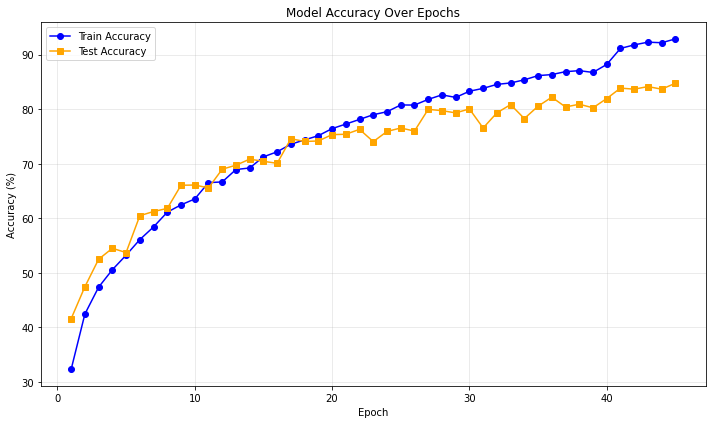

In [130]:
def plot_accuracy_curve(train_accuracies, test_accuracies, epochs):
    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epoch_range, test_accuracies, label='Test Accuracy', marker='s', color='orange')
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_accuracy_curve(train_accuracies, test_accuracies, epochs)

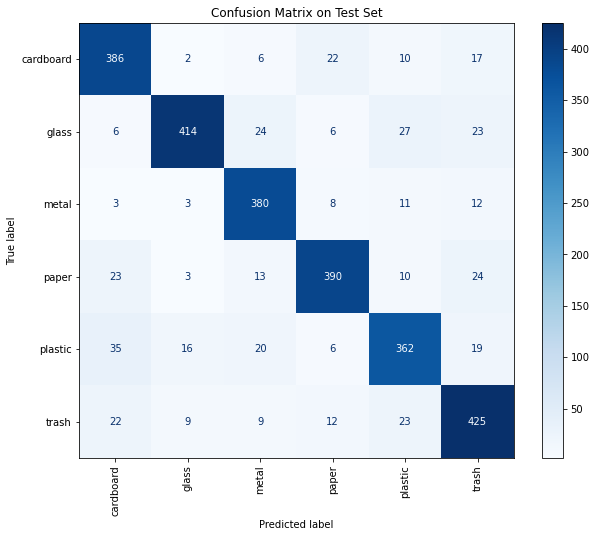

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.81      0.87      0.84       443
       glass       0.93      0.83      0.87       500
       metal       0.84      0.91      0.87       417
       paper       0.88      0.84      0.86       463
     plastic       0.82      0.79      0.80       458
       trash       0.82      0.85      0.83       500

    accuracy                           0.85      2781
   macro avg       0.85      0.85      0.85      2781
weighted avg       0.85      0.85      0.85      2781



In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Run model on test set and collect predictions
model_1.to(device)
model_1.eval()
all_preds = []
all_labels = []
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model_1(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(y.cpu().numpy().tolist())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix on Test Set')
plt.show()

print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

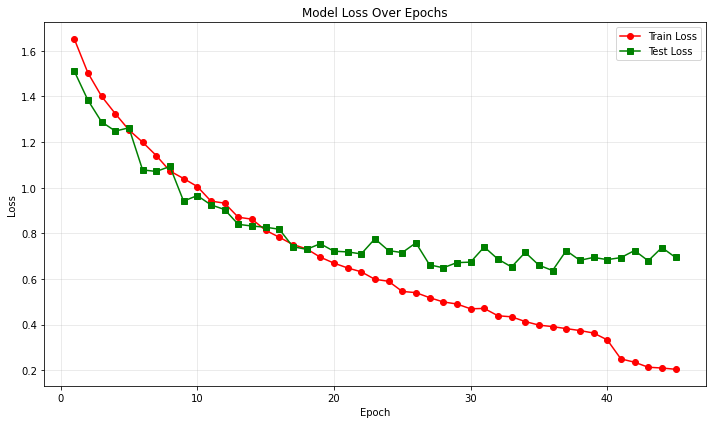

In [133]:
def plot_loss_curve(train_losses, test_losses, epochs):

    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    # Convert tensors to CPU if needed
    train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
    test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
    
    plt.plot(epoch_range, train_losses_cpu, label='Train Loss', marker='o', color='red')
    plt.plot(epoch_range, test_losses_cpu, label='Test Loss', marker='s', color='green')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function with your stored losses
plot_loss_curve(train_losses, test_losses, epochs)

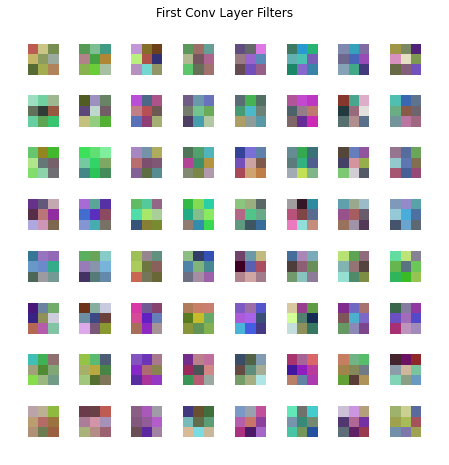

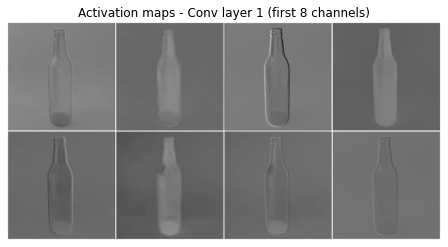

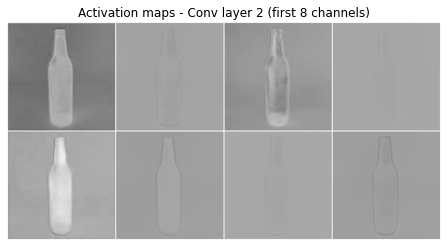

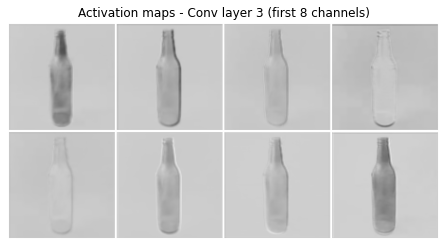

Sample ground-truth label: glass


In [134]:
# Visualize CNN filters (first conv layer) and activation maps for a sample image
from torchvision.utils import make_grid
import numpy as np
import torch.nn as nn

# Helper: find first few Conv2d layers in the model
def get_conv_layers(model, max_layers=3):
    convs = []
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            convs.append(m)
            if len(convs) >= max_layers:
                break
    return convs

# Visualize the learned filters of the first conv layer
conv_layers = get_conv_layers(model_1, max_layers=1)
if len(conv_layers) == 0:
    print('No Conv2d layers found in the model.')
else:
    conv0 = conv_layers[0]
    # conv0.weight shape: (out_chan, in_chan, kH, kW)
    w = conv0.weight.data.clone().cpu()
    # Normalize weights to 0..1 for visualization
    w_min, w_max = w.min(), w.max()
    w_norm = (w - w_min) / (w_max - w_min + 1e-8)
    # Make a grid (will show filters as RGB images when in_chan==3)
    grid = make_grid(w_norm, nrow=8, normalize=False, pad_value=1)
    plt.figure(figsize=(8, 8))
    plt.title('First Conv Layer Filters')
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Activation maps for a sample test image (first item in test set)
# Get a sample image from `test_data` (a Subset) and ensure it's an image tensor
try:
    sample_img, sample_label = test_data[0]
except Exception as e:
    # fallback to test_loader first batch
    print('Could not index test_data directly, using first batch from test_loader. Error:', e)
    batch = next(iter(test_loader))
    sample_img, sample_label = batch[0][0], batch[1][0]

# Prepare image and register hooks to capture activations
activations = []
hooks = []
def hook_fn(module, inp, out):
    activations.append(out.detach().cpu())

# Register hooks on the first 3 conv layers (or less if not present)
conv_layers = get_conv_layers(model_1, max_layers=3)
for conv in conv_layers:
    hooks.append(conv.register_forward_hook(hook_fn))

# Forward pass the sample image
model_1.to(device)
model_1.eval()
with torch.inference_mode():
    img_batch = sample_img.unsqueeze(0).to(device)
    _ = model_1(img_batch)

# Remove hooks
for h in hooks:
    h.remove()

# Plot activation maps from each hooked layer
for i, act in enumerate(activations):
    # act shape: (batch, channels, H, W)
    act = act[0]  # take the first (and only) batch item
    n_maps = min(8, act.shape[0])
    # normalize each map for display
    act_min, act_max = act.min(), act.max()
    act_norm = (act - act_min) / (act_max - act_min + 1e-8)
    maps = act_norm[:n_maps].unsqueeze(1)  # (n_maps,1,H,W)
    # make grid and plot
    grid = make_grid(maps, nrow=4, normalize=False, pad_value=1)
    plt.figure(figsize=(10, 4))
    plt.title(f'Activation maps - Conv layer {i+1} (first {n_maps} channels)')
    plt.imshow(grid.squeeze().numpy(), cmap='viridis') if grid.shape[0]==1 else plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis('off')
    plt.show()

print('Sample ground-truth label:', full_dataset.classes[sample_label])

In [18]:

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
else:
    print("GPU NOT detected!")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
GPU Name: NVIDIA GeForce RTX 3070
GPU Count: 1
